In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem

In [110]:
df_molDesc = pd.read_csv('data/processed/moldesc.csv')
df_morgan_FP = pd.read_csv('data/processed/morgan_fingerprint.csv')

In [111]:
print(df_molDesc.columns)
print(df_morgan_FP.columns)

Index(['action_gen', 'mol', 'MolWt', 'ExactMolWt', 'HeavyAtomMolWt',
       'MaxPartialCharge', 'MinPartialCharge', 'NumValenceElectrons',
       'MolLogP', 'weights_max', 'default', 'weights_none', 'NHOHCount',
       'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms',
       'NumRotatableBonds', 'RingCount'],
      dtype='object')
Index(['cid', 'smiles', 'action', 'action_gen', 'mol', '0', '1', '2', '3', '4',
       ...
       '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022',
       '1023'],
      dtype='object', length=1029)


In [112]:
df_molDesc.drop('action_gen', axis=1, inplace=True)
df_molDesc.drop('mol', axis=1, inplace=True)

In [113]:
df_combined = pd.concat([df_morgan_FP, df_molDesc], axis=1)

In [114]:
df_morg_vec = df_combined.loc[:, [str(i) for i in range(1024)]]

In [115]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import rand_score


## Phase 1

### Truncated SVD

In [116]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
df_morganFP_trunc = svd.fit_transform(df_morg_vec)


np.random.seed(42)
df_morganFP_trunc_scaled = df_morganFP_trunc
scaler = StandardScaler()
df_morganFP_trunc_scaled = pd.DataFrame(scaler.fit_transform(df_morganFP_trunc))
df_morganFP_trunc_scaled['action_gen'] = df_combined['action_gen']


### LDA

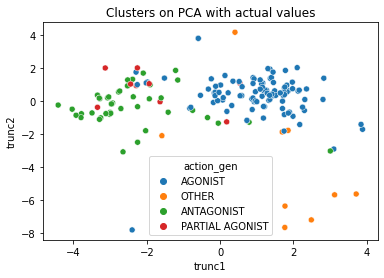

In [117]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

# normal LDA
n_comp = 2
# lda = LDA(n_components=n_comp).fit(df_morganFP_trunc_scaled.iloc[:, :-1], df_morganFP_trunc_scaled.iloc[:, -1])

# normal LDA with partial training set to prevent overfitting
# df_sample = df_morganFP_trunc_scaled.sample(n=140)
# lda = LDA(n_components=n_comp).fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
# X_train, X_test, y_train, y_test = train_test_split(df_morganFP_trunc_scaled.iloc[:, :-1], df_morganFP_trunc_scaled.iloc[:, -1], 
#                                                 train_size=0.6, random_state=42)
# lda = LDA(n_components=n_comp).fit(X_train, y_train)


# solve generalized eigenvalue problem
X_train, X_test, y_train, y_test = train_test_split(df_morganFP_trunc_scaled.iloc[:, :-1], df_morganFP_trunc_scaled.iloc[:, -1], 
                                                train_size=0.6, random_state=42)
lda = LDA(n_components=n_comp, solver='eigen', shrinkage=0.1).fit(X_train, y_train)

df_morganFP_trunc_scaled.drop("action_gen", axis=1, inplace=True)
# lda_results = lda.transform(X_train)
lda_results = lda.transform(df_morganFP_trunc_scaled)

lda_results = pd.DataFrame(lda_results, columns=['trunc' + str(i) for i in range(1, n_comp+1)])
sns.scatterplot(x='trunc1', y="trunc2", hue=df_combined['action_gen'], data=lda_results)
# sns.scatterplot(x='trunc1', y="trunc2", hue=y_train, data=lda_results)
plt.title('Clusters on PCA with actual values')
# plt.ylim([-13, 7])
# plt.xlim([-6, 12])
plt.show()


### Combine

In [118]:
df_combined.drop([str(i) for i in range(1024)], axis=1, inplace=True)
df_combined = pd.concat([df_combined, lda_results], axis=1)
# df_combined = pd.concat([df_combined, df_morganFP_trunc_scaled], axis=1)
df_combined

,cid,smiles,action,action_gen,mol,MolWt,ExactMolWt,HeavyAtomMolWt,MaxPartialCharge,MinPartialCharge,...,weights_none,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,RingCount,trunc1,trunc2
0,2159,CCN1CCCC1CNC(=O)C2=CC(=C(C=C2OC)N)S(=O)(=O)CC,AGONIST,AGONIST,<rdkit.Chem.rdchem.Mol object at 0x0000021051D...,369.487,369.172227,342.271,0.254647,-0.495842,...,0.687720,3,7,6,2,8,7,2,1.179901,-1.035497
1,2160,CN(C)CCC=C1C2=CC=CC=C2CCC3=CC=CC=C31,BINDER,OTHER,<rdkit.Chem.rdchem.Mol object at 0x0000021051D...,277.411,277.183050,254.227,0.001014,-0.309092,...,0.620380,0,1,1,0,1,3,3,1.853121,-1.781037
2,2562,CCN(CC)CCOCCOC(=O)C1(CCCC1)C2=CC=CC=C2,ANTAGONIST,ANTAGONIST,<rdkit.Chem.rdchem.Mol object at 0x0000021051D...,333.472,333.230394,302.224,0.316138,-0.462565,...,0.609808,0,4,4,0,4,10,2,0.789610,-1.283811
3,3345,CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3,AGONIST,AGONIST,<rdkit.Chem.rdchem.Mol object at 0x0000021051D...,336.479,336.220164,308.255,0.226459,-0.309290,...,0.794927,0,3,2,0,3,6,3,1.711894,0.497637
4,3821,CNC1(CCCCC1=O)C2=CC=CC=C2Cl,BINDER,OTHER,<rdkit.Chem.rdchem.Mol object at 0x0000021051D...,237.730,237.092042,221.602,0.156947,-0.304286,...,0.864922,1,2,2,1,3,2,2,1.692197,-1.877047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,132990963,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=C(C=C4)F,AGONIST,AGONIST,<rdkit.Chem.rdchem.Mol object at 0x0000021053E...,366.524,366.247127,335.276,0.122729,-0.297847,...,0.670214,0,2,2,0,3,5,4,1.974485,0.745654
167,132990975,C1CCC(CC1)N2CCN(CC2)C(CC3=CC=CC=C3)C4=CC=CC=C4F,AGONIST,AGONIST,<rdkit.Chem.rdchem.Mol object at 0x0000021053E...,366.524,366.247127,335.276,0.127497,-0.297847,...,0.670214,0,2,2,0,3,5,4,1.348428,0.346262
168,134156377,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC)O[C...,AGONIST,AGONIST,<rdkit.Chem.rdchem.Mol object at 0x0000021053E...,485.486,485.189711,454.238,0.335427,-0.492857,...,0.220231,8,12,8,4,12,4,5,1.093617,0.718660
169,137434175,CCC1=CC2=C(C(=C(N=C2C(=C1)F)N3CCC(CC3)NC4CCOCC...,ANTAGONIST,ANTAGONIST,<rdkit.Chem.rdchem.Mol object at 0x0000021053E...,453.562,453.254003,421.306,0.261461,-0.381329,...,0.578615,1,7,7,1,8,5,5,-2.705876,-0.459794


### LDA

In [121]:
# # df_morganFP_trunc_scaled = df_combined.loc[:, ['MaxPartialCharge', 'MinPartialCharge', 'MolLogP', 'NumHAcceptors', 'RingCount'] + [i for i in range(50)] + ['action_gen']]

# n_comp = 2
# # lda = LDA(n_components=n_comp).fit(df_morganFP_trunc_scaled.iloc[:, :-1], df_morganFP_trunc_scaled.iloc[:, -1])

# # normal LDA with partial training set to prevent overfitting
# # df_sample = df_morganFP_trunc_scaled.sample(n=140)
# # lda = LDA(n_components=n_comp).fit(df_sample.iloc[:, :-1], df_sample.iloc[:, -1])
# # X_train, X_test, y_train, y_test = train_test_split(df_morganFP_trunc_scaled.iloc[:, :-1], df_morganFP_trunc_scaled.iloc[:, -1], 
# #                                                 train_size=0.6, random_state=42)
# # lda = LDA(n_components=n_comp).fit(X_train, y_train)



# # solve generalized eigenvalue problem
# X_train, X_test, y_train, y_test = train_test_split(df_morganFP_trunc_scaled.iloc[:, :-1], df_morganFP_trunc_scaled.iloc[:, -1], 
#                                                 train_size=0.6, random_state=42)
# lda = LDA(n_components=n_comp, solver='eigen', shrinkage=0.1).fit(X_train, y_train)

# df_morganFP_trunc_scaled.drop("action_gen", axis=1, inplace=True)
# # lda_results = lda.transform(X_train)
# lda_results = lda.transform(df_morganFP_trunc_scaled)

# lda_results = pd.DataFrame(lda_results, columns=['trunc' + str(i) for i in range(1, n_comp+1)])
# sns.scatterplot(x='trunc1', y="trunc2", hue=df_combined['action_gen'], data=lda_results)
# # sns.scatterplot(x='trunc1', y="trunc2", hue=y_train, data=lda_results)
# plt.title('Clusters on PCA with actual values')
# # plt.ylim([-13, 7])
# # plt.xlim([-6, 12])
# plt.show()

c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\fongm\Anaconda3\envs\m2vec\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


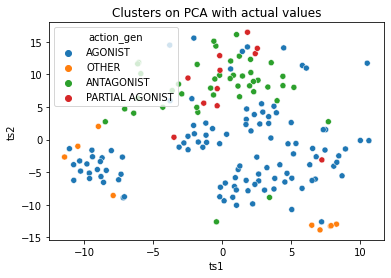

In [122]:
np.random.seed(42)
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
df_combined_scaled = StandardScaler().fit_transform(
    df_combined.loc[:, ['MaxPartialCharge', 'MinPartialCharge', 'MolLogP', 'NumHAcceptors', 'RingCount', 'trunc1', 'trunc2']])
    # df_combined.loc[:, ['MaxPartialCharge', 'MinPartialCharge', 'MolLogP', 'NumHAcceptors', 'RingCount'] + [i for i in range(50)]])
tsne_results = tsne.fit_transform(df_combined_scaled)

tsne_results = pd.DataFrame(tsne_results, columns=['ts1', 'ts2'])
sns.scatterplot(x='ts1', y="ts2", hue=df_combined['action_gen'], data=tsne_results)
plt.title('Clusters on PCA with actual values')
plt.show()

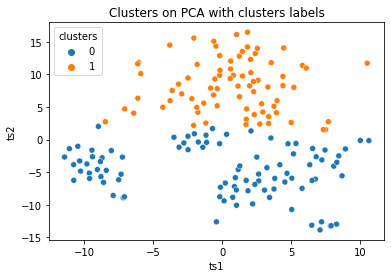

In [123]:
clustering_kmeans = KMeans(n_clusters=2)
tsne_results['clusters'] = clustering_kmeans.fit_predict(tsne_results)
sns.scatterplot(x="ts1", y="ts2", hue=tsne_results['clusters'], data=tsne_results)
plt.title('Clusters on PCA with clusters labels')
plt.show()

# clustering_kmeans = KMeans(n_clusters=4)
# lda_results['clusters'] = clustering_kmeans.fit_predict(lda_results)
# sns.scatterplot(x="trunc1", y="trunc2", hue=lda_results['clusters'], data=lda_results)
# plt.title('Clusters on PCA with clusters labels')
# plt.show()

In [ ]:
print(lda_results['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(lda_results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

lda_results['action_gen'] = df_combined['action_gen']
lda_results['action_gen_cluster'] = lda_results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(lda_results.action_gen, lda_results.action_gen_cluster))
lda_results[lda_results.action_gen == lda_results.action_gen_cluster].shape[0] / lda_results.shape[0]
# print('Accuracy', accuracy_score(lda_results.action_gen, lda_results.action_gen_cluster))
print(classification_report(lda_results.action_gen, lda_results.action_gen_cluster))


0    80
1    57
3    28
2     6
Name: clusters, dtype: int64
pairing_score:  0.7350533195734434
                 precision    recall  f1-score   support

        AGONIST       0.97      0.72      0.83       108
     ANTAGONIST       0.68      0.91      0.78        43
          OTHER       0.83      0.56      0.67         9
PARTIAL AGONIST       0.04      0.09      0.05        11

       accuracy                           0.72       171
      macro avg       0.63      0.57      0.58       171
   weighted avg       0.83      0.72      0.76       171



In [ ]:
print(tsne_results['clusters'].value_counts())
# sort keys based on number of values in each clusters
cluster_dict = dict(tsne_results['clusters'].value_counts())
cluster_dict = dict(sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)).keys()
cluster_dict = list(cluster_dict)

tsne_results['action_gen'] = df_combined['action_gen']
tsne_results['action_gen_cluster'] = tsne_results['clusters'].map({cluster_dict[0]: 'AGONIST', cluster_dict[1]: 'ANTAGONIST', cluster_dict[2]: 'PARTIAL AGONIST', cluster_dict[3]: 'OTHER'})

print('pairing_score: ', rand_score(tsne_results.action_gen, tsne_results.action_gen_cluster))
tsne_results[tsne_results.action_gen == tsne_results.action_gen_cluster].shape[0] / tsne_results.shape[0]
# print('Accuracy', accuracy_score(tsne_results.action_gen, tsne_results.action_gen_cluster))
print(classification_report(tsne_results.action_gen, tsne_results.action_gen_cluster))


2    53
0    46
1    45
3    27
Name: clusters, dtype: int64
pairing_score:  0.5861025111799105
                 precision    recall  f1-score   support

        AGONIST       0.85      0.42      0.56       108
     ANTAGONIST       0.24      0.26      0.25        43
          OTHER       0.15      0.44      0.22         9
PARTIAL AGONIST       0.16      0.64      0.25        11

       accuracy                           0.39       171
      macro avg       0.35      0.44      0.32       171
   weighted avg       0.61      0.39      0.44       171

